In [2]:
# Import calibration functions
# Run this to reimport without having to restart the whole notebook
import radial_velocity_functions
import importlib
importlib.reload(radial_velocity_functions)
from radial_velocity_functions import *

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import tqdm as tqdm
from tqdm import tqdm
import pandas as pd
from datetime import datetime
from scipy.interpolate import interp1d

# plt styles
matplotlib.rcParams["text.usetex"] = True
matplotlib.rcParams["font.family"] = "serif"
matplotlib.rcParams["font.size"] = 10 
matplotlib.rcParams['figure.dpi'] = 100

In [4]:
def compute_chunk_shift(x1, y1, y1_err, x2, y2, plot=False, ax=None):
    
    # Interp first file
    f1 = interp1d(x1, y1, kind='cubic', fill_value="extrapolate")
    f1_upper_err = interp1d(x1, y1 + y1_err, kind='cubic', fill_value="extrapolate")
    f1_lower_err = interp1d(x1, y1 - y1_err, kind='cubic', fill_value="extrapolate")

    c = 299792458 # m/s

    # ChiSquare fit model:
    def model_chi2(A):

        # Interpolate template
        # interp_x2 = x2 + A
        interp_x2 = x2 * (1 + A/c) # this should give proper RV, the wavelength should be stretched by a factor of (1 + v/c)
        f2 = interp1d(interp_x2, y2, kind='cubic', fill_value="extrapolate")

        # Find common x-range
        xmin = max([min(x1), min(interp_x2)])
        xmax = min([max(x1), max(interp_x2)])
        xnewCommon = np.linspace(xmin, xmax, 1000)
        
        # Evaluate interpolation
        ynew1 = f1(xnewCommon)
        ynew2 = f2(xnewCommon)

        # Evalute error interpolation
        ynew1_upper_err = f1_upper_err(xnewCommon)
        ynew1_lower_err = f1_lower_err(xnewCommon)

        ynew1_upper_err_abs = np.abs(ynew1 - ynew1_upper_err)
        ynew1_lower_err_abs = np.abs(ynew1 - ynew1_lower_err)
        ynew1_err = np.mean([ynew1_upper_err_abs, ynew1_lower_err_abs], axis=0) # pair wise mean
        
        # Compute chi2
        chi2 = np.sum(((ynew1 - ynew2) / ynew1_err)**2)
        return chi2
    model_chi2.errordef = 1
        
    # Init value
    # A_init = (peak2 / peak1 - 1 ) * c # shift between the two peaks
    A_init = 0

    # Compute bounds on A
    # x1_min, x1_max = min(x1), max(x1)
    # A_lower_bound = (x1_min / peak2 - 1 ) * c
    # A_upper_bound = (x1_max / peak2 - 1 ) * c
    # TODO: do something with minimum 10% overlap

    minuit = Minuit(model_chi2, A=A_init)
    # minuit.limits["A"] = (A_lower_bound, A_upper_bound)
    minuit.migrad()
    
    # Results
    valid = minuit.valid
    shift_min_final = minuit.values['A']
    shift_min_final_err = minuit.errors['A']
    forced = minuit.fmin.has_made_posdef_covar
    at_limit = minuit.fmin.has_parameters_at_limit

    if forced or at_limit:
        valid = False

    # Plot final shifted values
    if plot:
        if ax == None:
            fig, ax = plt.subplots(figsize=(14,6))

        ax.plot(x1, y1)
        ax.plot(x2 * (1 + shift_min_final/c), y2)

        if not valid:
            ax.set_facecolor('pink')


    return pd.DataFrame({
        'rv':    [shift_min_final],
        'err':    [shift_min_final_err],
        'valid': [valid],
    }), minuit

In [5]:
def get_chunks_from_order(spectra_data, order):

    y, y_err, x = get_spec_wavel(spectra_data, order, continuum_normalized=True)
    
    if len(x) < 10:
        return np.nan
    
    chunk_size = 140
    chunk_ids = create_chunk_ids(len(x), chunk_size)

    df = pd.DataFrame({
        "y": y,
        "y_err": y_err,
        "x": x,
        "order": [order] * len(y),
        "chunk": chunk_ids 
    })

    # remove leftovers from chunk creation
    df = df[df.chunk != -1]

    return df


def get_all_chunks(filename):
    spectra_data = load_spectra_fits(filename)
    orders_n = len(spectra_data)

    order_chunks = []
    for o in np.arange(orders_n):
        chunks = get_chunks_from_order(spectra_data, o)
        if chunks is not np.nan:
            order_chunks.append(chunks)

    return pd.concat(order_chunks)


def create_chunk_ids(list_size, chunk_size):

    # Find how many chunks of size we can make
    n = floor(list_size/chunk_size)
    rem = list_size % chunk_size # what is the remainder

    # Arrange chunk ids
    ids = []
    for i in np.arange(n):
        ids.append([i] * chunk_size)

    # Add the remainder
    # ids.append([np.concatenate(ids)[-1] + 1]*rem)
    ids.append([-1]*rem) # mark to exclude

    # Flatten
    ids = np.concatenate(ids)
    return ids



In [6]:
def plot_chunk(df1, df2, order, chunk_id):

    c1 = df1[(df1.order == order) & (df1.chunk == chunk_id)]
    c2 = df2[(df2.order == order) & (df2.chunk == chunk_id)]

    # Crop ends to make them cover the same x-range
    c1_xmin, c1_xmax = min(c1.x), max(c1.x)
    c2_xmin, c2_xmax = min(c2.x), max(c2.x)
    common_min, common_max = max([c1_xmin, c2_xmin]), min([c1_xmax, c2_xmax]) 
    c1 = c1[(c1.x > common_min) & (c1.x < common_max)]
    c2 = c2[(c2.x > common_min) & (c2.x < common_max)]

    plt.plot(c1.x, c1.y, ".", alpha=0.5)
    plt.plot(c2.x, c2.y, ".", alpha=0.5)


def plot_all_chunks_in_order(df1, df2, order):
    fig, axs = plt.subplots(nrows = 7, ncols=8, figsize=(10, 10))
    
    # select order
    df1 = df1[df1.order == order]
    df2 = df2[df2.order == order]

    # Find chunks
    chunks_list = np.intersect1d(np.unique(df1.chunk), np.unique(df2.chunk))

    for index in chunks_list:
        index = int(index)
        
        c1 = df1[df1.chunk == index]
        c2 = df2[df2.chunk == index]

        # Crop ends to make them cover the same x-range
        c1_xmin, c1_xmax = min(c1.x), max(c1.x)
        c2_xmin, c2_xmax = min(c2.x), max(c2.x)
        common_min, common_max = max([c1_xmin, c2_xmin]), min([c1_xmax, c2_xmax]) 
        c1 = c1[(c1.x > common_min) & (c1.x < common_max)]
        c2 = c2[(c2.x > common_min) & (c2.x < common_max)]

        axs.flat[index].plot(c1.x, c1.y, alpha=0.5)
        axs.flat[index].plot(c2.x, c2.y, alpha=0.5)
        
    for ax in axs.flat:
        ax.axes.xaxis.set_ticklabels([])
        ax.axes.yaxis.set_ticklabels([])
        ax.axes.xaxis.set_ticks([])
        ax.axes.yaxis.set_ticks([])

    fig.tight_layout()


def compute_all_chunk_shifts(df1, df2, use_nth_chunk=1):
    results = []
    for order in np.arange(40, 76):
        chunks = np.intersect1d(np.unique(df1.chunk), np.unique(df2.chunk))
        for i in chunks[::use_nth_chunk]:
            c1 = df1[(df1.order == order) & (df1.chunk == i)]
            c2 = df2[(df2.order == order) & (df2.chunk == i)]

            # Crop ends to make them cover the same x-range
            c1_xmin, c1_xmax = min(c1.x), max(c1.x)
            c2_xmin, c2_xmax = min(c2.x), max(c2.x)
            common_min, common_max = max([c1_xmin, c2_xmin]), min([c1_xmax, c2_xmax]) 
            c1 = c1[(c1.x > common_min) & (c1.x < common_max)]
            c2 = c2[(c2.x > common_min) & (c2.x < common_max)]

            df_result, minuit = compute_chunk_shift(c1.x, c1.y, c1.y_err, c2.x, c2.y, plot=False)
            results.append(df_result)

    df_result = pd.concat(results)
    return df_result


In [5]:
filenames = get_all_spectra_filenames()
df1 = get_all_chunks(filenames[0])
df2 = get_all_chunks(filenames[5])

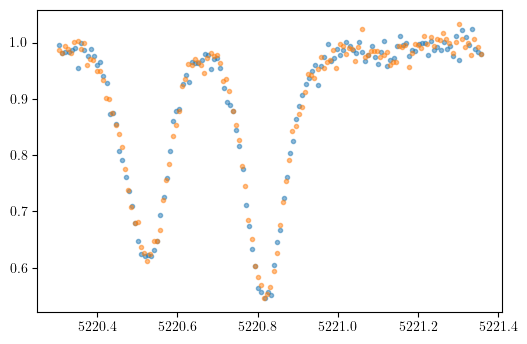

In [8]:
plot_chunk(df1, df2, 42, 49)

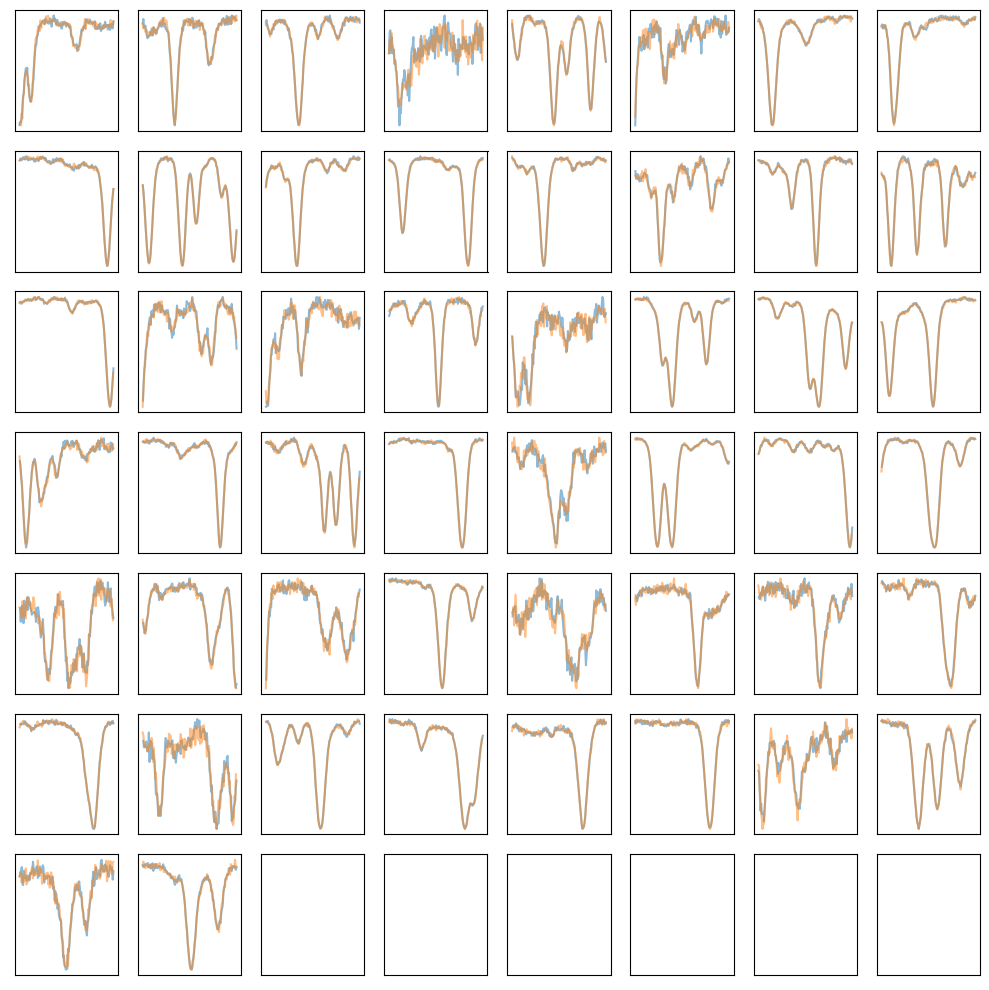

In [9]:
plot_all_chunks_in_order(df1, df2, 40)

In [9]:
filenames = get_all_spectra_filenames()
df1 = get_all_chunks(filenames[0])
df2 = get_all_chunks(filenames[15])

df_result = compute_all_chunk_shifts(df1, df2, 4)

E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.
E VariableMetricBuilder Initial matrix not pos.def.


(396.9249299433895, 8.695387485387238)

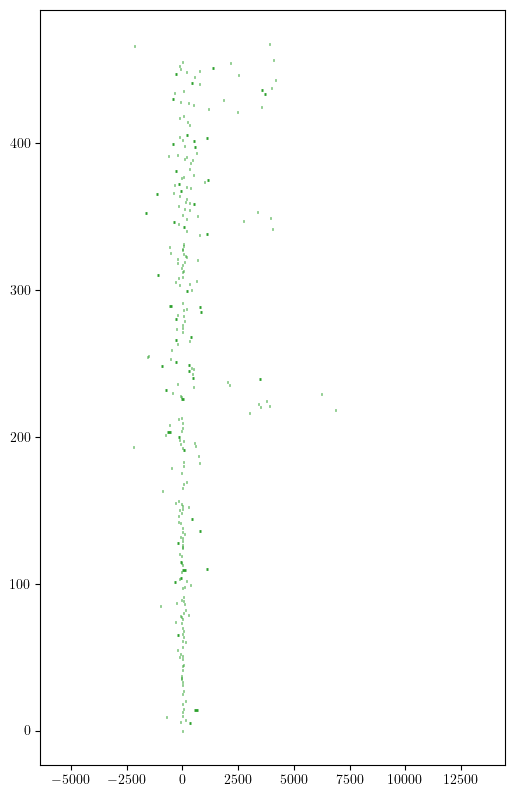

In [10]:
# df_result
plt.figure(figsize=(6, 10))
plt.errorbar(df_result.rv, np.arange(len(df_result)), xerr=df_result.err, fmt="none", linewidth=2, color = "C2")
np.mean(df_result.rv), np.median(df_result.rv)

In [11]:
N_files = -1 # for all
# N_files = 20
N_processes = 6

# Get list of files and find all features
filenames = get_spectra_filenames_without_duplicate_dates(SPECTRA_PATH_34411)
if N_files != -1:
    assert N_files > 0, "N_files is negative or zero"
    assert N_files <= len(filenames), "N_files is longer than number of data files"
    filenames = filenames[:N_files]

# Find features in all files 
chunks = []
print("Finding chunks for all files...")
for filename in tqdm(filenames):
    chunks.append(get_all_chunks(filename))


# Setup coords :: Compute one list of coords
size = len(filenames)
coords = []
for x in np.arange(size):
    for y in np.arange(x, size):
        if x != y:
            coords.append((x, y)) 
        
        
# Define function for each process
def compute_shift_for_coords_chunk(coords):
    x = coords[0]
    y = coords[1]
    shifts = compute_all_chunk_shifts(chunks[x], chunks[y], 15)
    return shifts


if __name__ == '__main__':
    import multiprocess
    pool = multiprocess.Pool(processes = N_processes)

    # With progress bar
    result = []
    print("Computeing shifts for all files combinations...")
    for r in tqdm(pool.imap_unordered(compute_shift_for_coords_chunk, coords), total=len(coords)):
        result.append(r)
        
    print("Finished!")

    # np.save("lily_data_results/15th_chunk_34411_ms_bary", [result, coords])

In [ ]:
# 15th_chunk_34411_ms_bary took 8 minutes 

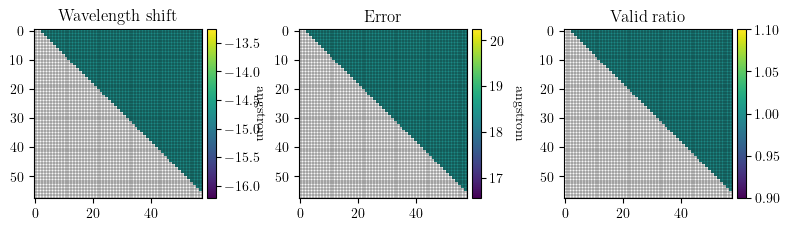

In [13]:
def parse_2(result, coords):
    
    size = np.max(np.max(coords)) + 1
    diff_matrix, diff_matrix_err, diff_matrix_valid = make_nan_matrix(size), make_nan_matrix(size), make_nan_matrix(size)

    for coord, shifts in zip(coords, result):

        # Split 
        # shift, shift_err, shift_valid = shifts[0], shifts[1], shifts[3]
    
        rv = shifts.rv
        err = shifts.err
        valid = shifts.valid

        rv = np.median(rv)
        err = np.mean(err)
        valid = len(valid[valid])/len(valid)

        x = coord[0]
        y = coord[1]

        diff_matrix[x, y] = rv
        diff_matrix_err[x, y] = err
        diff_matrix_valid[x, y] = valid
        
    return diff_matrix, diff_matrix_err, diff_matrix_valid


result, coords = np.load("lily_data_results/15th_chunk_34411_ms_bary_error_fix.npy", allow_pickle=True)
plot_matrix(*parse_2(result, coords))

(153.47510411380344, 14.740222251232922)

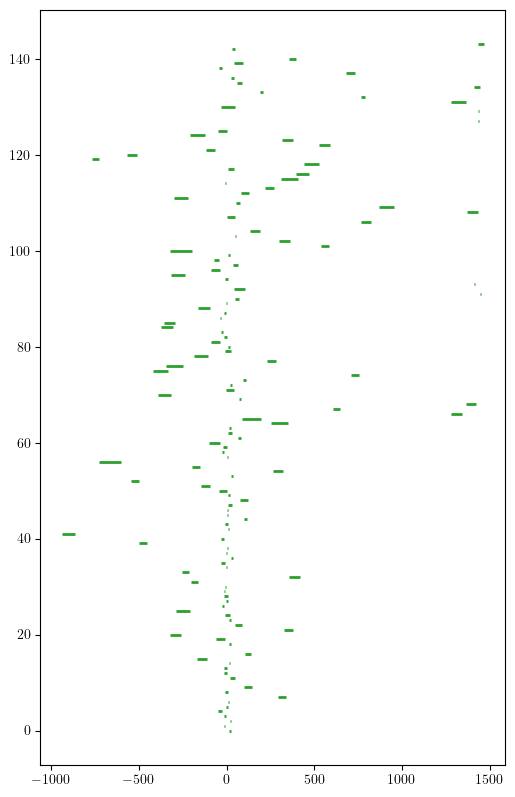

In [399]:
plt.figure(figsize=(6, 10))
plt.errorbar(result[0].rv, np.arange(len(result[0])), xerr=result[0].err, fmt="none", linewidth=2, color = "C2")
np.mean(result[0].rv), np.median(result[0].rv)

### Stop

Can't really get good results...